# Netflix Clustering using K-Means

## 1. Setup and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine Learning
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)

## 2. Data Loading and Initial Exploration

In [2]:
netflix = pd.read_csv('netflix_titles.csv')
print(f"Dataset loaded successfully!")
print(f"Shape: {netflix.shape[0]} rows × {netflix.shape[1]} columns")

Dataset loaded successfully!
Shape: 8807 rows × 12 columns


#### 2a. Display basic information

In [3]:
print("Dataset Overview:")
netflix.info()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [4]:
print("First 5 Records:")
netflix.head()

First 5 Records:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


#### 2b. Check for missing values

In [5]:
print("Missing Values Analysis:")
missing_netflix = pd.DataFrame({
    'Column': netflix.columns,
    'Missing_Count': netflix.isnull().sum().values,
    'Missing_Percentage': (netflix.isnull().sum().values / len(netflix) * 100).round(2)
})
missing_netflix = missing_netflix[missing_netflix['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
print(missing_netflix.to_string(index=False))

Missing Values Analysis:
    Column  Missing_Count  Missing_Percentage
  director           2634               29.91
   country            831                9.44
      cast            825                9.37
date_added             10                0.11
    rating              4                0.05
  duration              3                0.03


## 3. Data Cleaning and Preprocessing

In [6]:
netflix_clean = netflix.copy()

#### 3a. Handle Missing Values

In [7]:
netflix_clean['director'] = netflix_clean['director'].fillna('Not Given')
netflix_clean['cast'] = netflix_clean['cast'].fillna('Not Given')
netflix_clean['country'] = netflix_clean['country'].fillna('Not Given')
netflix_clean['rating'] = netflix_clean['rating'].fillna('Not Rated')
netflix_clean['date_added'] = pd.to_datetime(netflix_clean['date_added'], errors='coerce')

#### 3b. Extract Features from date_added

In [8]:
netflix_clean['year_added'] = netflix_clean['date_added'].dt.year
netflix_clean['month_added'] = netflix_clean['date_added'].dt.month
netflix_clean['year_added'] = netflix_clean['year_added'].fillna(netflix_clean['year_added'].median())
netflix_clean['month_added'] = netflix_clean['month_added'].fillna(netflix_clean['month_added'].median())

#### 3c. Parse Duration into numerical format

In [9]:
def parse_duration(row):
    """Convert duration to minutes"""
    if pd.isna(row['duration']):
        return 0

    duration_str = str(row['duration'])

    if row['type'] == 'Movie':
        try:
            return int(duration_str.split()[0])
        except:
            return 90  # Default movie length
    else:  # TV Show
        try:
            n_seasons = int(duration_str.split()[0])
            return n_seasons * 10 * 45  # Approximate: 10 episodes × 45 min
        except:
            return 450  # Default: 1 season

netflix_clean['duration_numeric'] = netflix_clean.apply(parse_duration, axis=1)

#### 3d. Extract primary country and genre

In [10]:
netflix_clean['country_primary'] = netflix_clean['country'].apply(
    lambda x: x.split(',')[0].strip() if x != 'Not Given' else 'Not Given'
)

netflix_clean['genre_primary'] = netflix_clean['listed_in'].apply(
    lambda x: x.split(',')[0].strip() if pd.notna(x) else 'Not Given'
)

#### 3e. Create count features

In [11]:
netflix_clean['n_countries'] = netflix_clean['country'].apply(
    lambda x: len(x.split(',')) if x != 'Not Given' else 0
)

netflix_clean['n_genres'] = netflix_clean['listed_in'].apply(
    lambda x: len(x.split(',')) if pd.notna(x) else 0
)

netflix_clean['cast_size'] = netflix_clean['cast'].apply(
    lambda x: len(x.split(',')) if x != 'Not Given' else 0
)

#### 3f. Binary features

In [12]:
netflix_clean['has_director'] = (netflix_clean['director'] != 'Not Given').astype(int)

print("Data cleaning completed!")
print(f"New features created:")
print("- duration_numeric: Numerical duration in minutes")
print("- year_added, month_added: Temporal features")
print("- country_primary, genre_primary: Main country and genre")
print("- n_countries, n_genres, cast_size: Count features")
print("- has_director: Binary indicator")

Data cleaning completed!
New features created:
- duration_numeric: Numerical duration in minutes
- year_added, month_added: Temporal features
- country_primary, genre_primary: Main country and genre
- n_countries, n_genres, cast_size: Count features
- has_director: Binary indicator


## 4. Exploratory Data Analysis (EDA)

#### 4a. Content type distribution

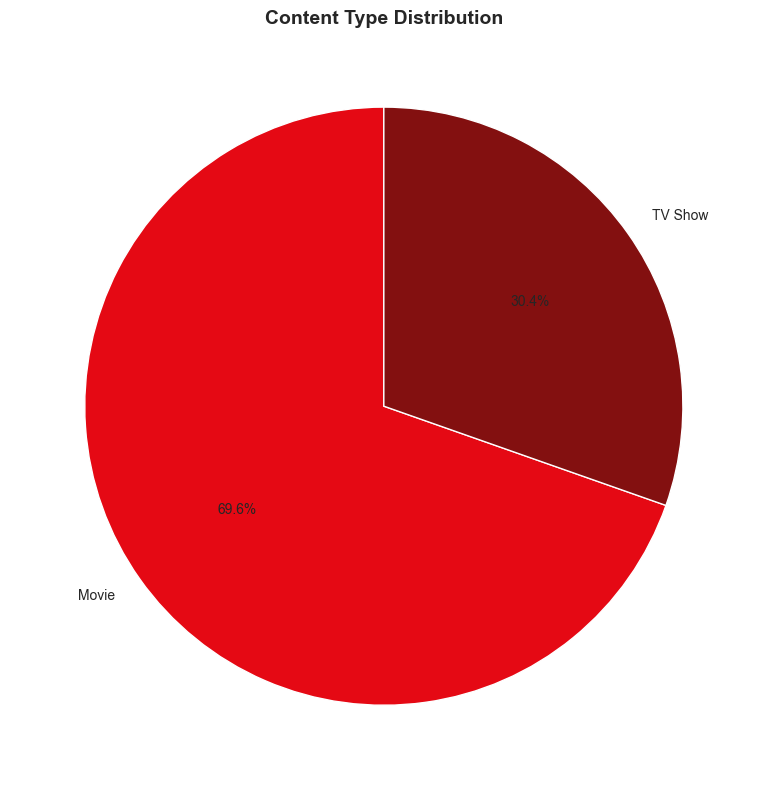

In [13]:
plt.figure(figsize=(8, 8))
colors = ['#E50914', '#831010']
netflix_clean['type'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                         colors=colors, startangle=90)
plt.title('Content Type Distribution', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

#### 4b. Top 10 countries

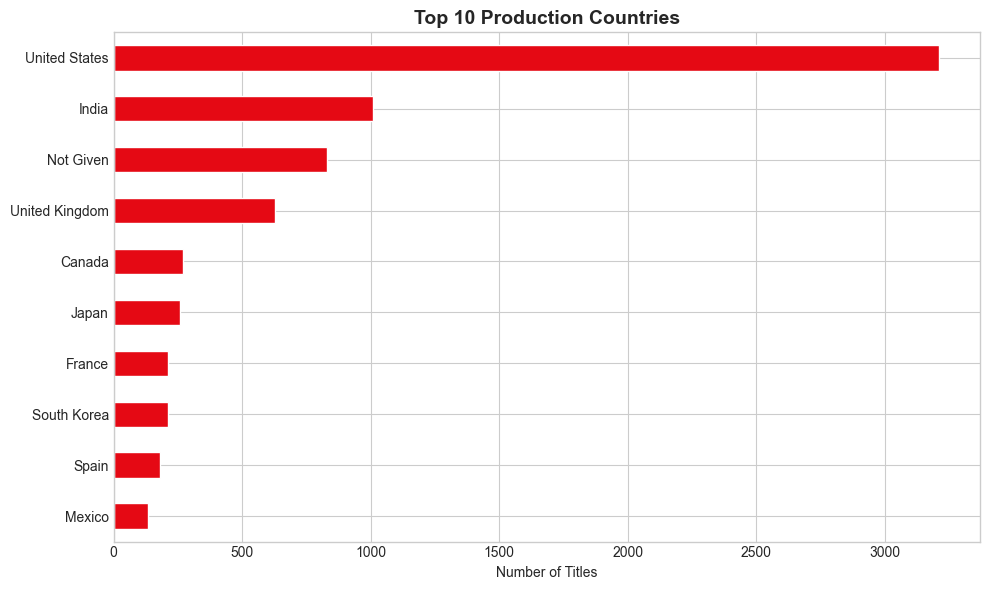

In [14]:
plt.figure(figsize=(10, 6))
top_countries = netflix_clean['country_primary'].value_counts().head(10)
top_countries.plot(kind='barh', color='#E50914')
plt.title('Top 10 Production Countries', fontsize=14, fontweight='bold')
plt.xlabel('Number of Titles')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### 4c. Rating distribution

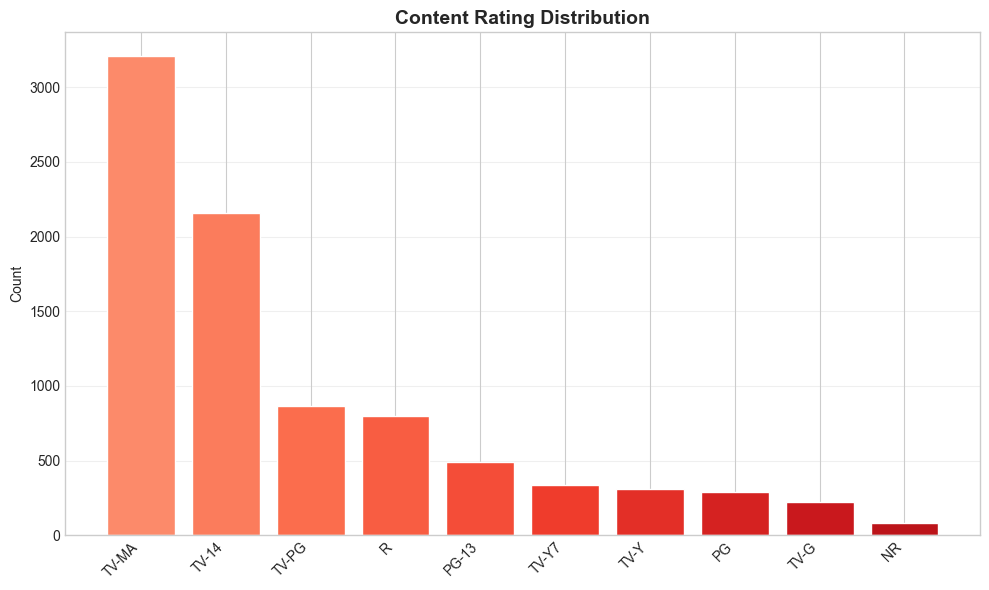

In [15]:
plt.figure(figsize=(10, 6))
rating_counts = netflix_clean['rating'].value_counts().head(10)
bars = plt.bar(range(len(rating_counts)), rating_counts.values,
               color=plt.cm.Reds(np.linspace(0.4, 0.8, len(rating_counts))))
plt.xticks(range(len(rating_counts)), rating_counts.index, rotation=45, ha='right')
plt.title('Content Rating Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 4d. Release year trend

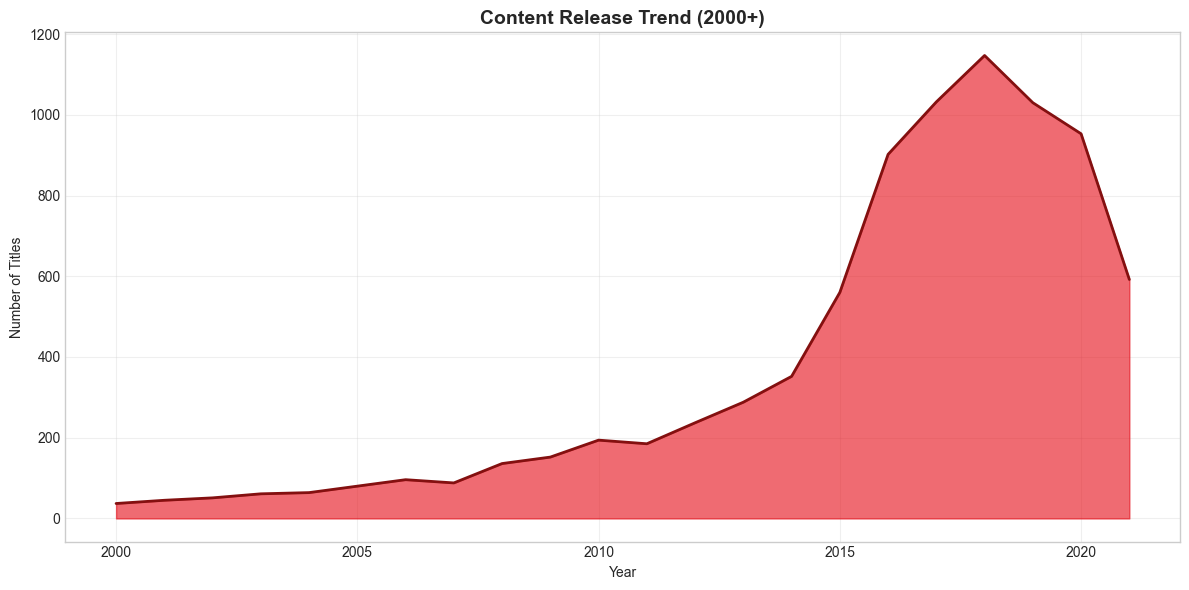

In [16]:
plt.figure(figsize=(12, 6))
release_years = netflix_clean['release_year'].value_counts().sort_index()
recent_years = release_years[release_years.index >= 2000]
plt.fill_between(recent_years.index, recent_years.values, alpha=0.6, color='#E50914')
plt.plot(recent_years.index, recent_years.values, color='#831010', linewidth=2)
plt.title('Content Release Trend (2000+)', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 4e. Top genres

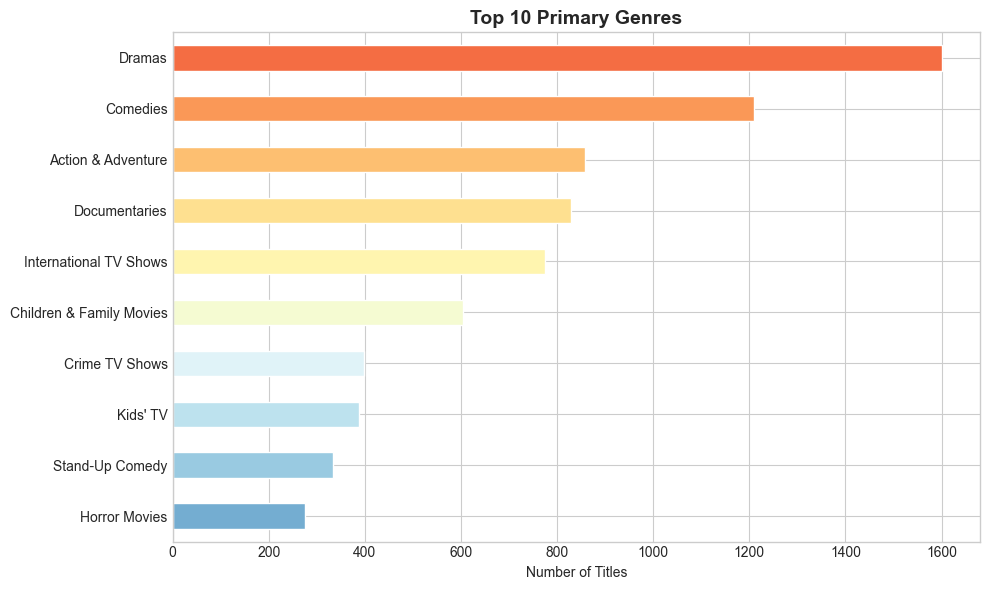

In [17]:
plt.figure(figsize=(10, 6))
top_genres = netflix_clean['genre_primary'].value_counts().head(10)
top_genres.plot(kind='barh', color=plt.cm.RdYlBu(np.linspace(0.2, 0.8, 10)))
plt.title('Top 10 Primary Genres', fontsize=14, fontweight='bold')
plt.xlabel('Number of Titles')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### 4f. Movie duration distribution

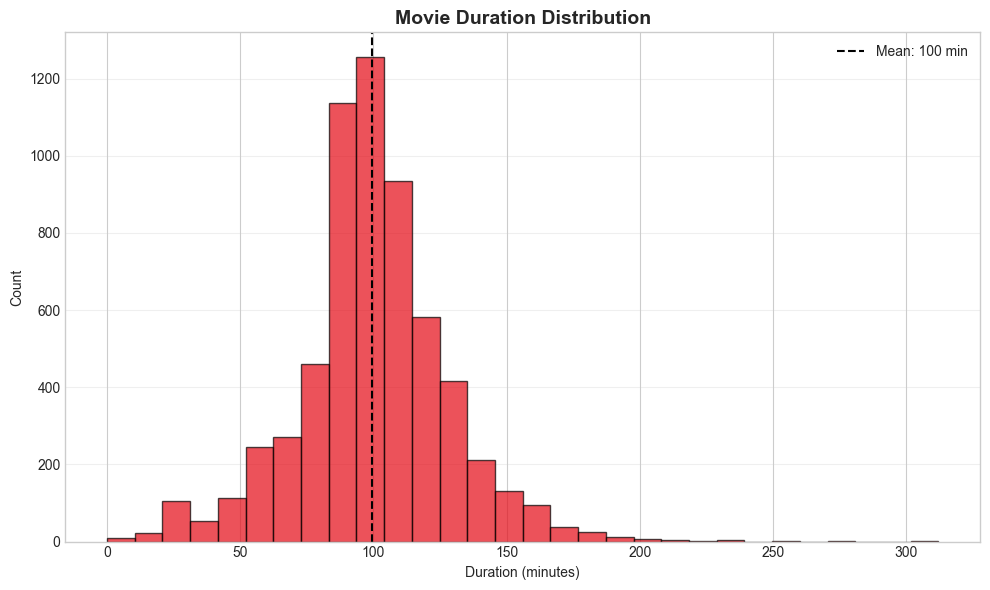

In [18]:
plt.figure(figsize=(10, 6))
movie_durations = netflix_clean[netflix_clean['type'] == 'Movie']['duration_numeric']
plt.hist(movie_durations, bins=30, edgecolor='black', color='#E50914', alpha=0.7)
plt.axvline(movie_durations.mean(), color='black', linestyle='--',
           label=f'Mean: {movie_durations.mean():.0f} min')
plt.title('Movie Duration Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


#### 4g. TV show seasons distribution

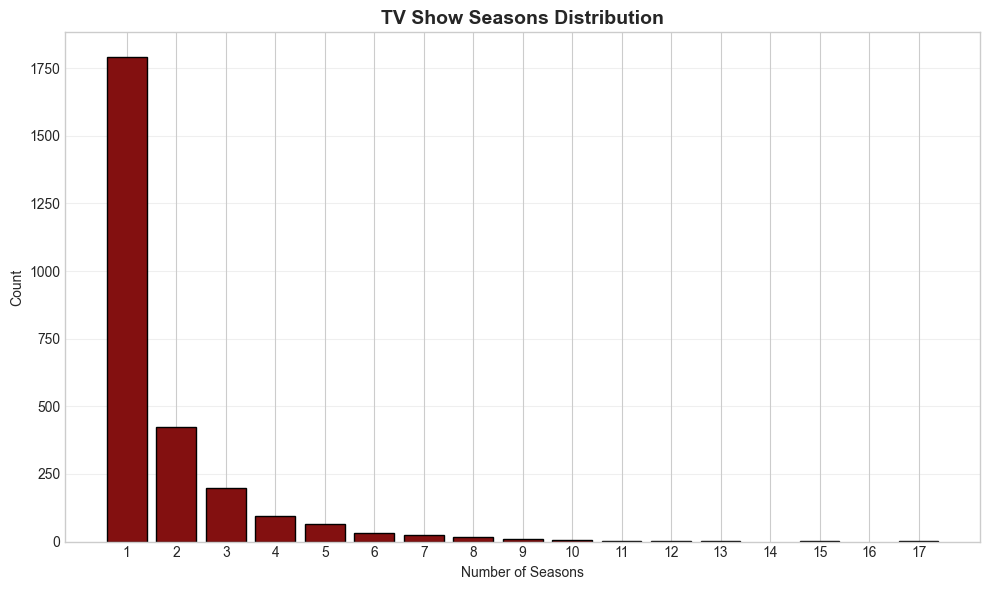

In [19]:
plt.figure(figsize=(10, 6))
tv_durations = netflix_clean[netflix_clean['type'] == 'TV Show']['duration'].str.extract('(\d+)')[0].astype(float)
tv_counts = tv_durations.value_counts().sort_index()
plt.bar(tv_counts.index, tv_counts.values, color='#831010', edgecolor='black', width=0.8)
plt.title('TV Show Seasons Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Seasons')
plt.ylabel('Count')
plt.xticks(range(1, int(tv_counts.index.max())+1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 4h. Content added by year

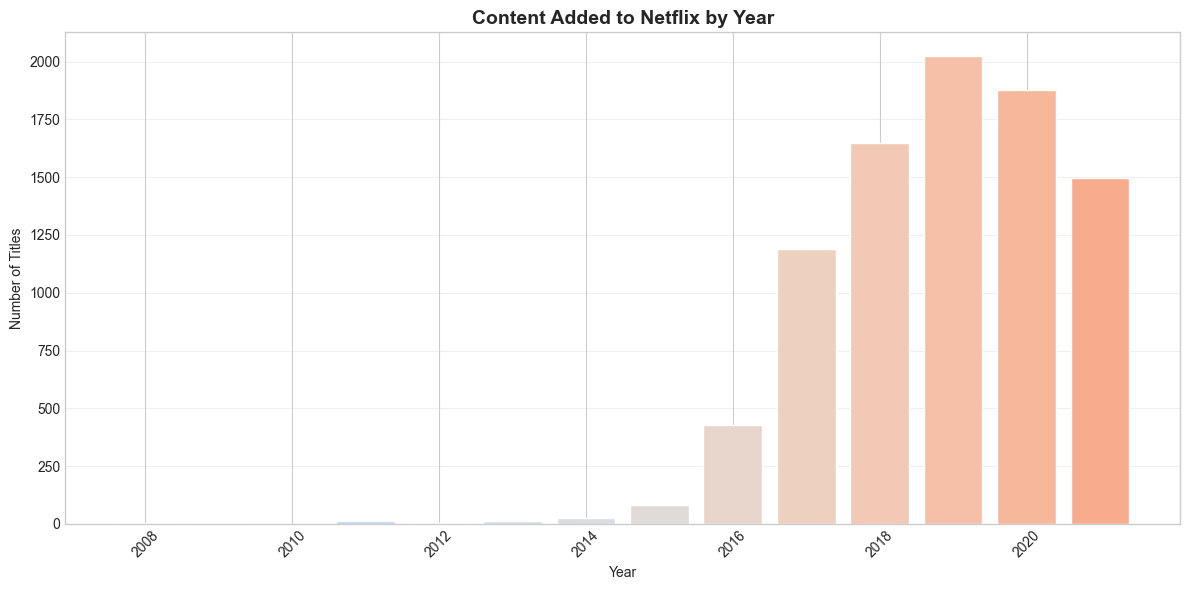

In [20]:
plt.figure(figsize=(12, 6))
added_by_year = netflix_clean.groupby('year_added').size()
plt.bar(added_by_year.index, added_by_year.values,
        color=plt.cm.coolwarm(np.linspace(0.3, 0.7, len(added_by_year))))
plt.title('Content Added to Netflix by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.xticks(added_by_year.index[::2], added_by_year.index[::2].astype(int), rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 4i. Cast size distribution

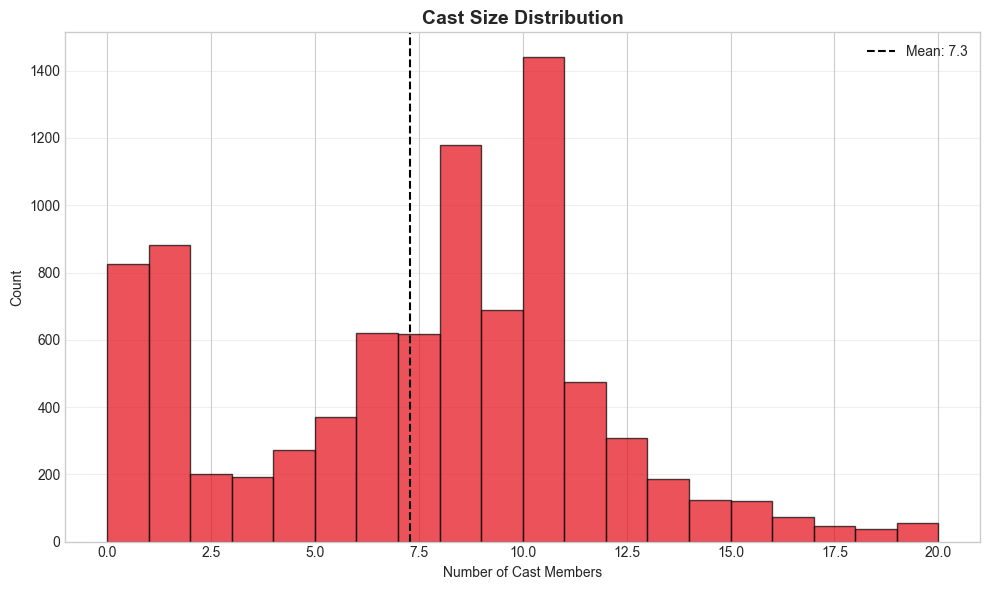

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(netflix_clean['cast_size'], bins=20, edgecolor='black',
         color='#E50914', alpha=0.7, range=(0, 20))
plt.axvline(netflix_clean['cast_size'].mean(), color='black',
           linestyle='--', label=f'Mean: {netflix_clean["cast_size"].mean():.1f}')
plt.title('Cast Size Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Cast Members')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 4j. Number of genres per title

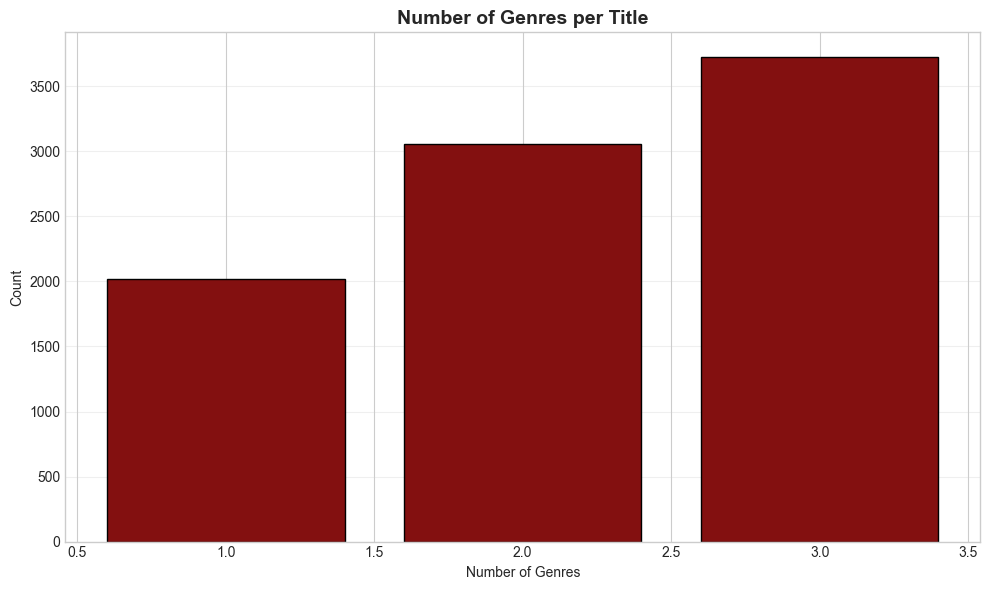

In [22]:
plt.figure(figsize=(10, 6))
genre_counts = netflix_clean['n_genres'].value_counts().sort_index()
plt.bar(genre_counts.index, genre_counts.values, color='#831010', edgecolor='black')
plt.title('Number of Genres per Title', fontsize=14, fontweight='bold')
plt.xlabel('Number of Genres')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 4k. Content type by year

<Figure size 1200x600 with 0 Axes>

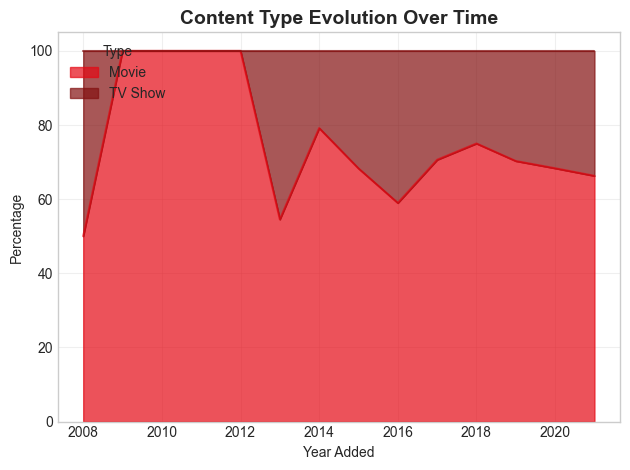

In [23]:
plt.figure(figsize=(12, 6))
year_type = pd.crosstab(netflix_clean['year_added'], netflix_clean['type'])
year_type_pct = year_type.div(year_type.sum(axis=1), axis=0) * 100
year_type_pct.plot(kind='area', color=['#E50914', '#831010'], alpha=0.7)
plt.title('Content Type Evolution Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year Added')
plt.ylabel('Percentage')
plt.legend(title='Type', loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 4l. Correlation Heatmap

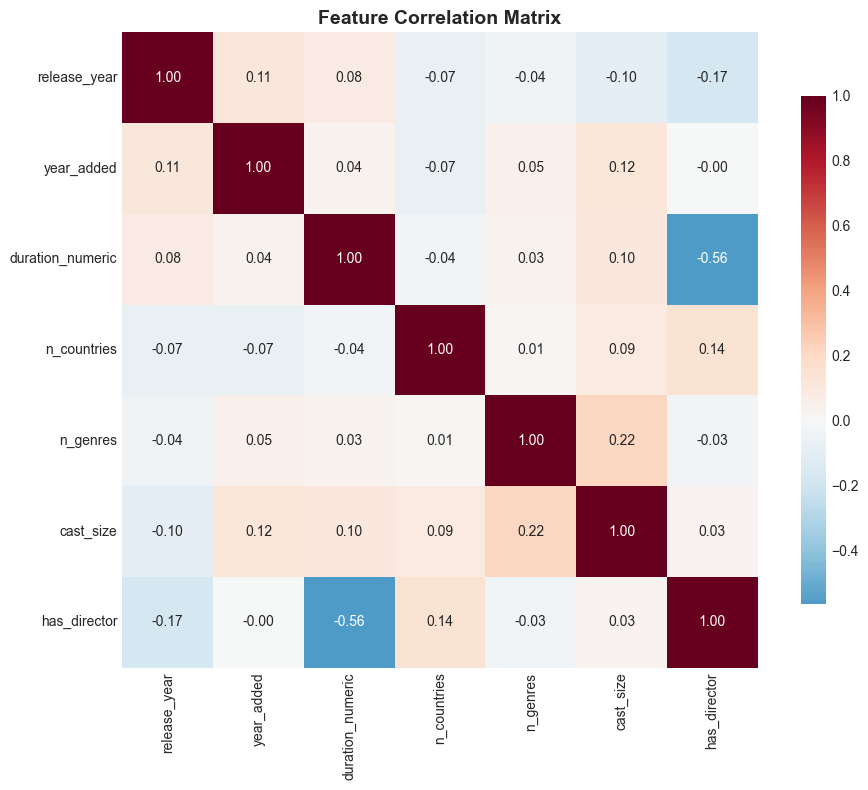

In [24]:
plt.figure(figsize=(10, 8))
numeric_cols = ['release_year', 'year_added', 'duration_numeric',
               'n_countries', 'n_genres', 'cast_size', 'has_director']
corr_matrix = netflix_clean[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f',
           cmap='RdBu_r', center=0, square=True,
           cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Feature Engineering for Clustering

In [25]:
features_list = []
feature_names = []

#### 5a. Numerical features

In [26]:
numerical_features = ['release_year', 'duration_numeric', 'year_added',
                     'month_added', 'n_countries', 'n_genres', 'cast_size']

numerical_netflix = netflix_clean[numerical_features].fillna(netflix_clean[numerical_features].median())
features_list.append(numerical_netflix.values)
feature_names.extend(numerical_features)
print(f"Added {len(numerical_features)} numerical features")

Added 7 numerical features


#### 5b. Binary features

In [27]:
binary_features = ['has_director']
features_list.append(netflix_clean[binary_features].values)
feature_names.extend(binary_features)
print(f"Added {len(binary_features)} binary features")

Added 1 binary features


#### 5c. Type encoding

In [28]:
type_encoded = pd.get_dummies(netflix_clean['type'], prefix='type')
features_list.append(type_encoded.values)
feature_names.extend(type_encoded.columns.tolist())
print(f"Added {len(type_encoded.columns)} type features")

Added 2 type features


#### 5d. Rating encoding

In [29]:
top_ratings = netflix_clean['rating'].value_counts().head(8).index
netflix_clean['rating_grouped'] = netflix_clean['rating'].apply(
    lambda x: x if x in top_ratings else 'Other'
)
rating_encoded = pd.get_dummies(netflix_clean['rating_grouped'], prefix='rating')
features_list.append(rating_encoded.values)
feature_names.extend(rating_encoded.columns.tolist())
print(f"Added {len(rating_encoded.columns)} rating features")

Added 9 rating features


#### 5e. Genre multi-label encoding

In [30]:
mlb = MultiLabelBinarizer()
genres_split = netflix_clean['listed_in'].apply(
    lambda x: [g.strip() for g in x.split(',')] if pd.notna(x) else []
)
genre_encoded = mlb.fit_transform(genres_split)
features_list.append(genre_encoded)
feature_names.extend([f'genre_{g}' for g in mlb.classes_])
print(f"Added {len(mlb.classes_)} genre features")

Added 42 genre features


#### 5f. Country encoding

In [31]:
top_countries = netflix_clean['country_primary'].value_counts().head(15).index
netflix_clean['country_grouped'] = netflix_clean['country_primary'].apply(
    lambda x: x if x in top_countries else 'Other'
)
country_encoded = pd.get_dummies(netflix_clean['country_grouped'], prefix='country')
features_list.append(country_encoded.values)
feature_names.extend(country_encoded.columns.tolist())
print(f"Added {len(country_encoded.columns)} country features")

Added 16 country features


#### 5g. Text features from desciption

In [32]:
tfinetflix = TfidfVectorizer(max_features=30, stop_words='english')
description_features = tfinetflix.fit_transform(
    netflix_clean['description'].fillna('')
).toarray()
features_list.append(description_features)
feature_names.extend([f'tfinetflix_{word}' for word in tfinetflix.get_feature_names_out()])
print(f"Added {description_features.shape[1]} text features")

Added 30 text features


In [33]:
# Combine all features
X = np.hstack(features_list)

print(f"Final Feature Matrix Shape: {X.shape}")
print(f"Total Features: {len(feature_names)}")

# Display feature breakdown
feature_breakdown = pd.DataFrame({
    'Category': ['Numerical', 'Binary', 'Type', 'Rating', 'Genre', 'Country', 'Text'],
    'Count': [len(numerical_features), len(binary_features),
             len(type_encoded.columns), len(rating_encoded.columns),
             len(mlb.classes_), len(country_encoded.columns),
             description_features.shape[1]]
})
print("Feature Breakdown:")
print(feature_breakdown.to_string(index=False))

Final Feature Matrix Shape: (8807, 107)
Total Features: 107
Feature Breakdown:
 Category  Count
Numerical      7
   Binary      1
     Type      2
   Rating      9
    Genre     42
  Country     16
     Text     30


## 6. Feature Scaling

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features scaled successfully!")
print(f"Shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean()}")
print(f"Std: {X_scaled.std()}")

Features scaled successfully!
Shape: (8807, 107)
Mean: -1.930271484923162e-18
Std: 0.9999999999999972


## 7. Optimal Number of Clusters

In [35]:
# Test different values of k
K_range = range(2, 16)
metrics = {
    'k': list(K_range),
    'inertia': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': []
}

# Calculate metrics for each k
for k in K_range:
    print(f"Testing k={k}...", end=' ')

    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)

    # Calculate metrics
    metrics['inertia'].append(kmeans.inertia_)

    # Use sampling for large datasets to speed up silhouette calculation
    sample_size = min(5000, len(X_scaled))
    metrics['silhouette'].append(
        silhouette_score(X_scaled, labels, sample_size=sample_size)
    )

    metrics['davies_bouldin'].append(davies_bouldin_score(X_scaled, labels))
    metrics['calinski_harabasz'].append(calinski_harabasz_score(X_scaled, labels))

    print("✓")

# Convert to DataFrame for easier handling
metrics_netflix = pd.DataFrame(metrics)

print("Clustering Metrics Summary:")
print(metrics_netflix.to_string(index=False))

Testing k=2... ✓
Testing k=3... ✓
Testing k=4... ✓
Testing k=5... ✓
Testing k=6... ✓
Testing k=7... ✓
Testing k=8... ✓
Testing k=9... ✓
Testing k=10... ✓
Testing k=11... ✓
Testing k=12... ✓
Testing k=13... ✓
Testing k=14... ✓
Testing k=15... ✓
Clustering Metrics Summary:
 k       inertia  silhouette  davies_bouldin  calinski_harabasz
 2 888755.771059    0.109518        3.746909         530.953943
 3 868723.031537    0.019914        4.464584         373.078071
 4 853878.574994    0.025252        4.180860         304.026503
 5 839319.501329    0.028073        3.839060         270.119319
 6 828147.891876    0.031019        3.623713         242.730547
 7 817379.629156    0.031055        3.426148         224.239024
 8 801914.932432    0.012766        3.630731         220.130111
 9 790964.400650    0.052820        3.393737         210.483826
10 781826.608655    0.055974        3.203676         200.686083
11 775529.645522    0.042708        3.564468         189.205281
12 759221.666853    0.06

#### 7a. Visualize clustering metrics - Elbow method

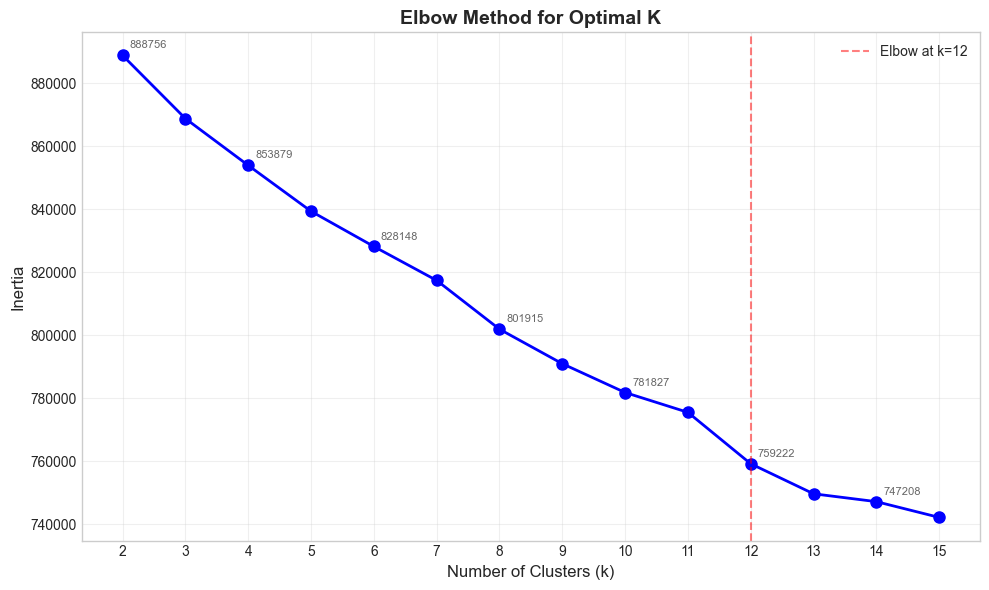

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_netflix['k'], metrics_netflix['inertia'], 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(metrics_netflix['k'])

# Mark the elbow point (using simple heuristic)
if len(metrics_netflix) > 2:
    diffs = np.diff(metrics_netflix['inertia'])
    diffs2 = np.diff(diffs)
    elbow_idx = np.argmax(diffs2) + 2  # +2 because of double diff
    plt.axvline(x=elbow_idx, color='red', linestyle='--', alpha=0.5,
                label=f'Elbow at k={elbow_idx}')
    plt.legend(loc='upper right')

# Add value annotations
for i, (k, inertia) in enumerate(zip(metrics_netflix['k'], metrics_netflix['inertia'])):
    if i % 2 == 0:  # Annotate every other point to avoid crowding
        plt.annotate(f'{inertia:.0f}',
                    xy=(k, inertia),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8,
                    alpha=0.7)

plt.tight_layout()
plt.show()

#### 7b. Silhouette Score

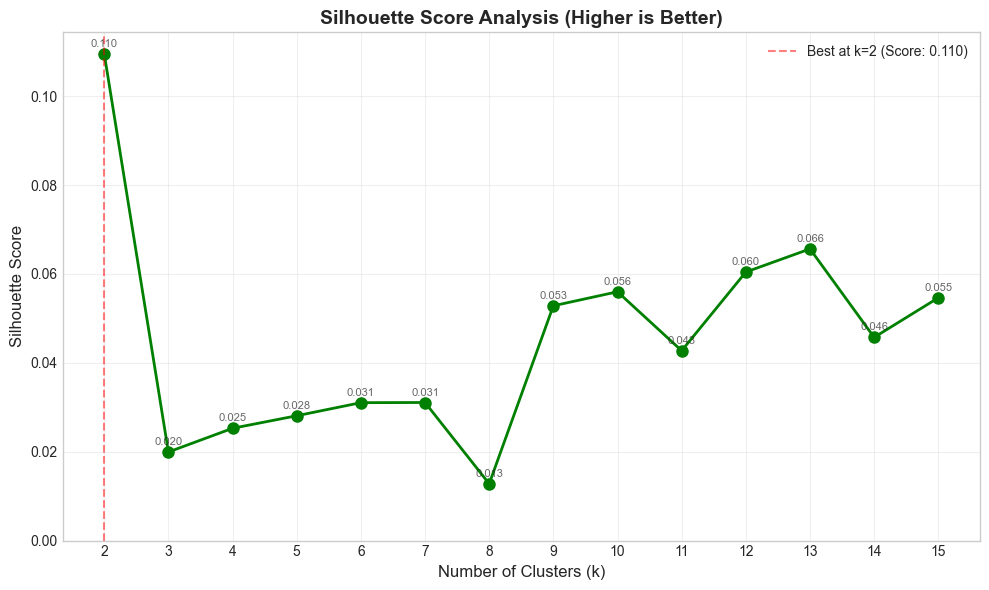

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_netflix['k'], metrics_netflix['silhouette'], 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score Analysis (Higher is Better)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(metrics_netflix['k'])

# Mark the best silhouette score
best_silhouette_k = metrics_netflix.loc[metrics_netflix['silhouette'].idxmax(), 'k']
best_silhouette_score = metrics_netflix.loc[metrics_netflix['silhouette'].idxmax(), 'silhouette']
plt.axvline(x=best_silhouette_k, color='red', linestyle='--', alpha=0.5,
           label=f'Best at k={best_silhouette_k:.0f} (Score: {best_silhouette_score:.3f})')

# Add value annotations
for k, score in zip(metrics_netflix['k'], metrics_netflix['silhouette']):
    plt.annotate(f'{score:.3f}',
                xy=(k, score),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center',
                fontsize=8,
                alpha=0.7)

plt.legend(loc='best')
plt.ylim(bottom=0)  # Start y-axis at 0 for better interpretation
plt.tight_layout()
plt.show()

#### 7c. Davies-Bouldin score

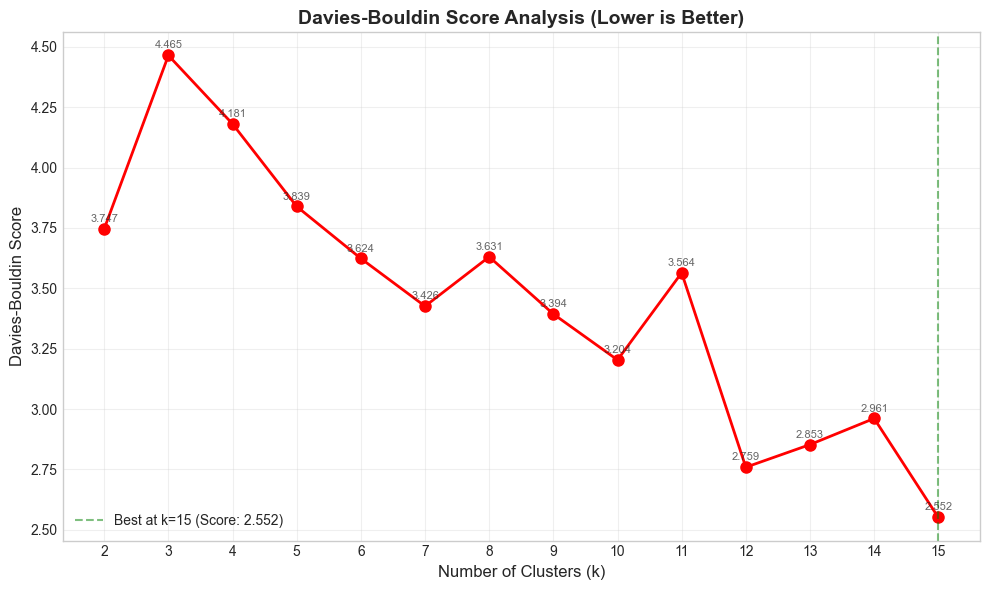

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_netflix['k'], metrics_netflix['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Davies-Bouldin Score', fontsize=12)
plt.title('Davies-Bouldin Score Analysis (Lower is Better)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(metrics_netflix['k'])

# Mark the best Davies-Bouldin score
best_db_k = metrics_netflix.loc[metrics_netflix['davies_bouldin'].idxmin(), 'k']
best_db_score = metrics_netflix.loc[metrics_netflix['davies_bouldin'].idxmin(), 'davies_bouldin']
plt.axvline(x=best_db_k, color='green', linestyle='--', alpha=0.5,
           label=f'Best at k={best_db_k:.0f} (Score: {best_db_score:.3f})')

# Add value annotations
for k, score in zip(metrics_netflix['k'], metrics_netflix['davies_bouldin']):
    plt.annotate(f'{score:.3f}',
                xy=(k, score),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center',
                fontsize=8,
                alpha=0.7)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### 7d. Calinski-Harabasz score

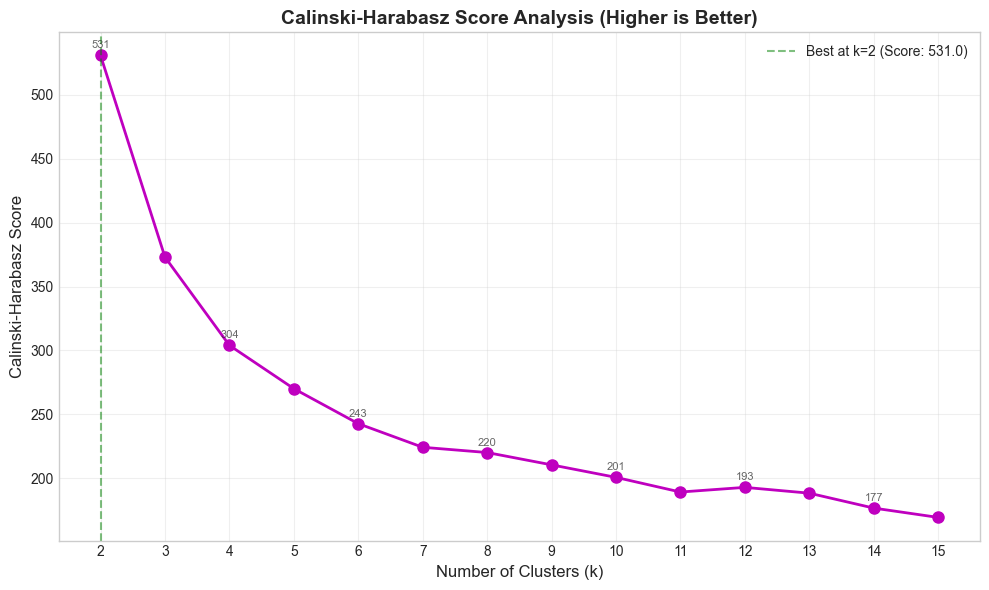

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_netflix['k'], metrics_netflix['calinski_harabasz'], 'mo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Calinski-Harabasz Score', fontsize=12)
plt.title('Calinski-Harabasz Score Analysis (Higher is Better)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(metrics_netflix['k'])

# Mark the best Calinski-Harabasz score
best_ch_k = metrics_netflix.loc[metrics_netflix['calinski_harabasz'].idxmax(), 'k']
best_ch_score = metrics_netflix.loc[metrics_netflix['calinski_harabasz'].idxmax(), 'calinski_harabasz']
plt.axvline(x=best_ch_k, color='green', linestyle='--', alpha=0.5,
           label=f'Best at k={best_ch_k:.0f} (Score: {best_ch_score:.1f})')

# Add value annotations for every other point to avoid crowding
for i, (k, score) in enumerate(zip(metrics_netflix['k'], metrics_netflix['calinski_harabasz'])):
    if i % 2 == 0:  # Annotate every other point
        plt.annotate(f'{score:.0f}',
                    xy=(k, score),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center',
                    fontsize=8,
                    alpha=0.7)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [41]:
optimal_k = int(best_silhouette_k)  # Using silhouette score as primary metric
print("Optimal Cluster Selection:")
print(f"Silhouette Score suggests: k = {best_silhouette_k:.0f}")
print(f"Davies-Bouldin Score suggests: k = {best_db_k:.0f}")
print(f"Calinski-Harabasz Score suggests: k = {best_ch_k:.0f}")
print(f"Selected optimal k = {optimal_k}")

Optimal Cluster Selection:
Silhouette Score suggests: k = 2
Davies-Bouldin Score suggests: k = 15
Calinski-Harabasz Score suggests: k = 2
Selected optimal k = 2


## 8. K-Means Clustering

In [42]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
netflix_clean['cluster'] = kmeans_final.fit_predict(X_scaled)

# Calculate final metrics
final_silhouette = silhouette_score(X_scaled, netflix_clean['cluster'],
                                   sample_size=min(5000, len(X_scaled)))
final_db = davies_bouldin_score(X_scaled, netflix_clean['cluster'])
final_ch = calinski_harabasz_score(X_scaled, netflix_clean['cluster'])

print("Clustering Complete!")
print("Final Clustering Metrics:")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Davies-Bouldin Score: {final_db:.4f}")
print(f"Calinski-Harabasz Score: {final_ch:.2f}")

# Cluster distribution
print("Cluster Distribution:")
cluster_dist = netflix_clean['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_dist.items():
    percentage = (count / len(netflix_clean)) * 100
    print(f"Cluster {cluster_id}: {count:4d} titles ({percentage:5.1f}%)")

Clustering Complete!
Final Clustering Metrics:
Silhouette Score: 0.1056
Davies-Bouldin Score: 3.7469
Calinski-Harabasz Score: 530.95
Cluster Distribution:
Cluster 0: 2675 titles ( 30.4%)
Cluster 1: 6132 titles ( 69.6%)


## 9. Cluster Analysis and Profiling

In [43]:
cluster_profiles = []

for cluster_id in sorted(netflix_clean['cluster'].unique()):
    cluster_data = netflix_clean[netflix_clean['cluster'] == cluster_id]

    profile = {
        'Cluster': cluster_id,
        'Size': len(cluster_data),
        'Percentage': f"{(len(cluster_data)/len(netflix_clean)*100):.1f}%",
        'Primary_Type': cluster_data['type'].mode()[0],
        'Top_Genre': cluster_data['genre_primary'].mode()[0],
        'Top_Rating': cluster_data['rating'].mode()[0],
        'Top_Country': cluster_data['country_primary'].mode()[0],
        'Avg_Release_Year': f"{cluster_data['release_year'].mean():.0f}",
        'Avg_Duration': f"{cluster_data['duration_numeric'].mean():.0f}",
        'Avg_Cast_Size': f"{cluster_data['cast_size'].mean():.1f}"
    }

    cluster_profiles.append(profile)

# Create profile DataFrame
profile_netflix = pd.DataFrame(cluster_profiles)

print("Cluster Profiles Summary:")
print(profile_netflix.to_string(index=False))

Cluster Profiles Summary:
 Cluster  Size Percentage Primary_Type              Top_Genre Top_Rating   Top_Country Avg_Release_Year Avg_Duration Avg_Cast_Size
       0  2675      30.4%      TV Show International TV Shows      TV-MA United States             2017          794           7.3
       1  6132      69.6%        Movie                 Dramas      TV-MA United States             2013          100           7.3


#### 9a. Detailed cluster characteristics - Content type distribution by cluster

<Figure size 1000x600 with 0 Axes>

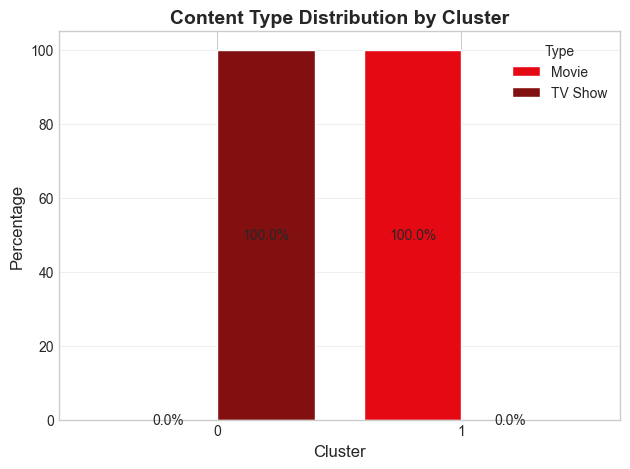

In [44]:
n_clusters = optimal_k

plt.figure(figsize=(10, 6))
cluster_type = pd.crosstab(netflix_clean['cluster'], netflix_clean['type'], normalize='index') * 100
cluster_type.plot(kind='bar', color=['#E50914', '#831010'], width=0.8)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Content Type Distribution by Cluster', fontsize=14, fontweight='bold')
plt.legend(title='Type', loc='upper right')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

#### 9b. Top genres by cluster

<Figure size 1200x600 with 0 Axes>

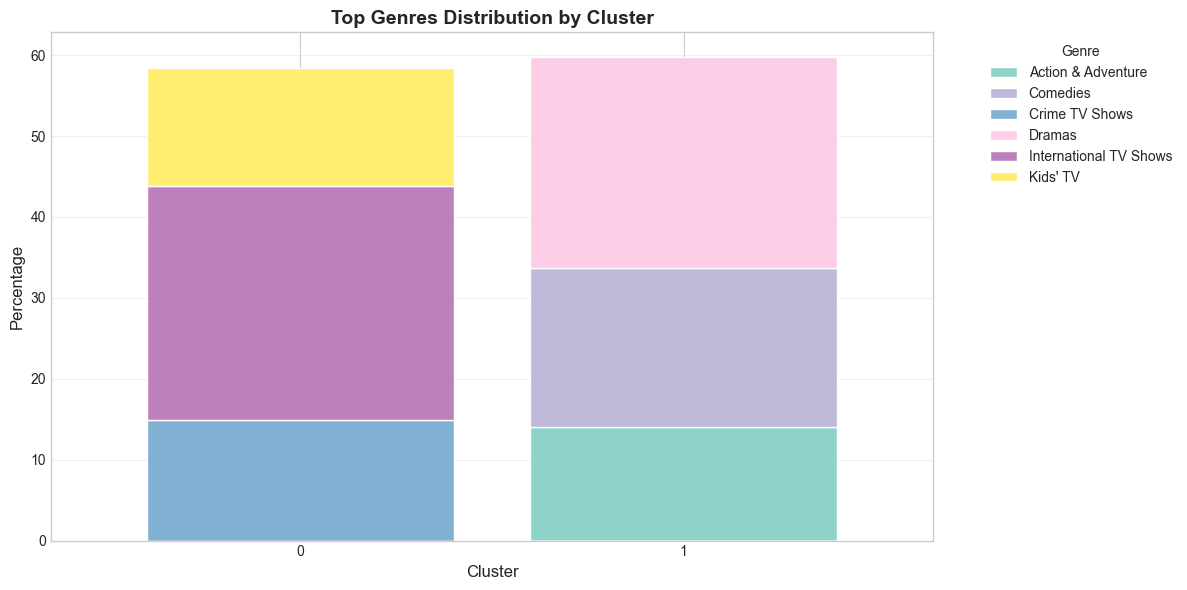

In [45]:
plt.figure(figsize=(12, 6))

# Prepare data
genre_cluster_data = []
for cluster_id in sorted(netflix_clean['cluster'].unique()):
    cluster_data = netflix_clean[netflix_clean['cluster'] == cluster_id]
    top_genre = cluster_data['genre_primary'].value_counts().head(3)
    for genre, count in top_genre.items():
        genre_cluster_data.append({
            'Cluster': cluster_id,
            'Genre': genre,
            'Percentage': (count / len(cluster_data)) * 100
        })

genre_cluster_netflix = pd.DataFrame(genre_cluster_data)
genre_pivot = genre_cluster_netflix.pivot(index='Cluster', columns='Genre', values='Percentage').fillna(0)

# Create stacked bar plot
genre_pivot.plot(kind='bar', stacked=True, colormap='Set3', width=0.8, figsize=(12, 6))
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Top Genres Distribution by Cluster', fontsize=14, fontweight='bold')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 9c. Average feature heatmap

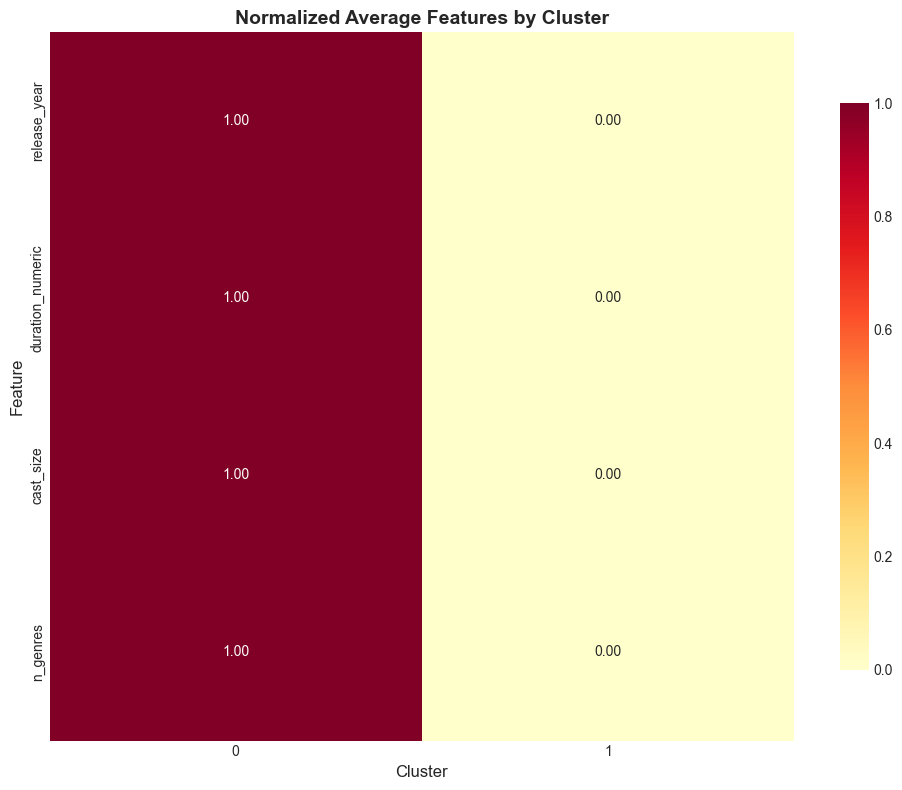

<Figure size 1200x600 with 0 Axes>

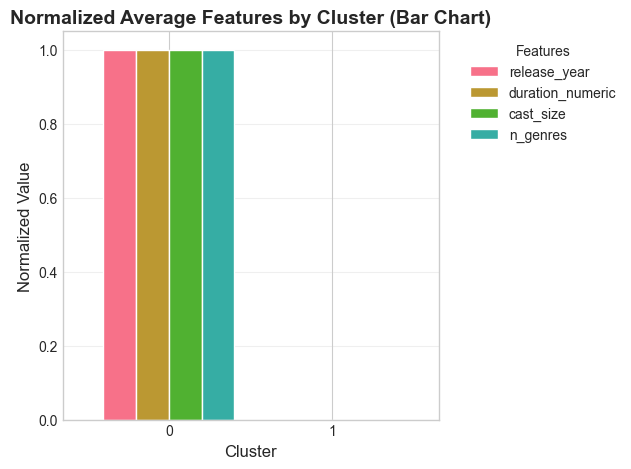

In [46]:
plt.figure(figsize=(10, 8))

feature_cols = ['release_year', 'duration_numeric', 'cast_size', 'n_genres']
cluster_features = netflix_clean.groupby('cluster')[feature_cols].mean()
cluster_features_norm = (cluster_features - cluster_features.min()) / (cluster_features.max() - cluster_features.min())

sns.heatmap(cluster_features_norm.T, annot=True, fmt='.2f', cmap='YlOrRd',
           cbar_kws={"shrink": 0.8}, square=False)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Normalized Average Features by Cluster', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Also create a bar plot version for better comparison
plt.figure(figsize=(12, 6))
cluster_features_norm.plot(kind='bar', width=0.8)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.title('Normalized Average Features by Cluster (Bar Chart)', fontsize=14, fontweight='bold')
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 9d. Release year distribution

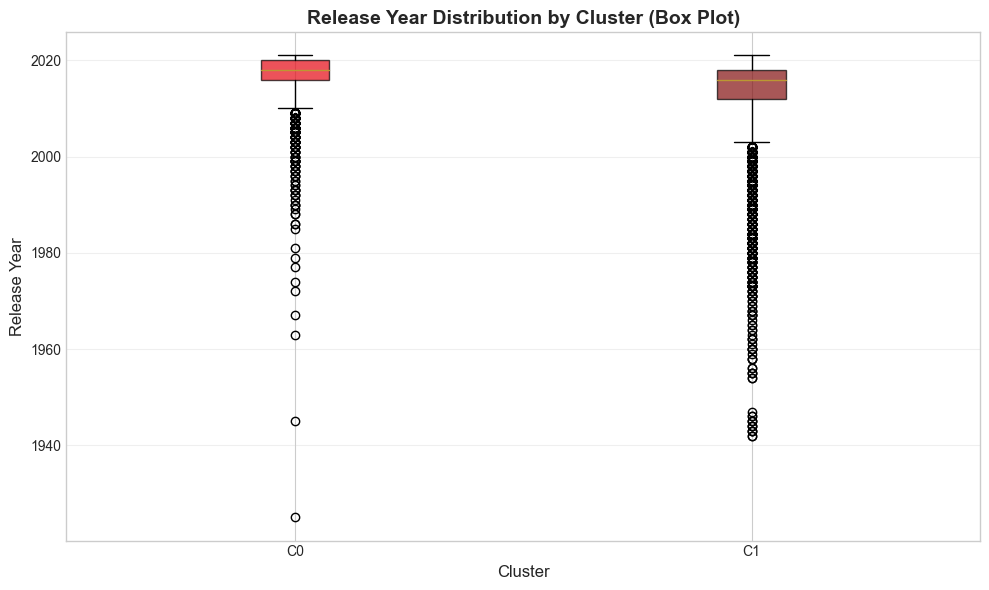

In [47]:
plt.figure(figsize=(10, 6))
release_year_data = [netflix_clean[netflix_clean['cluster'] == c]['release_year'].values
                     for c in sorted(netflix_clean['cluster'].unique())]
bp = plt.boxplot(release_year_data, labels=[f'C{i}' for i in sorted(netflix_clean['cluster'].unique())],
                 patch_artist=True)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Release Year', fontsize=12)
plt.title('Release Year Distribution by Cluster (Box Plot)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 9e. Rating distribution by cluster

<Figure size 1200x600 with 0 Axes>

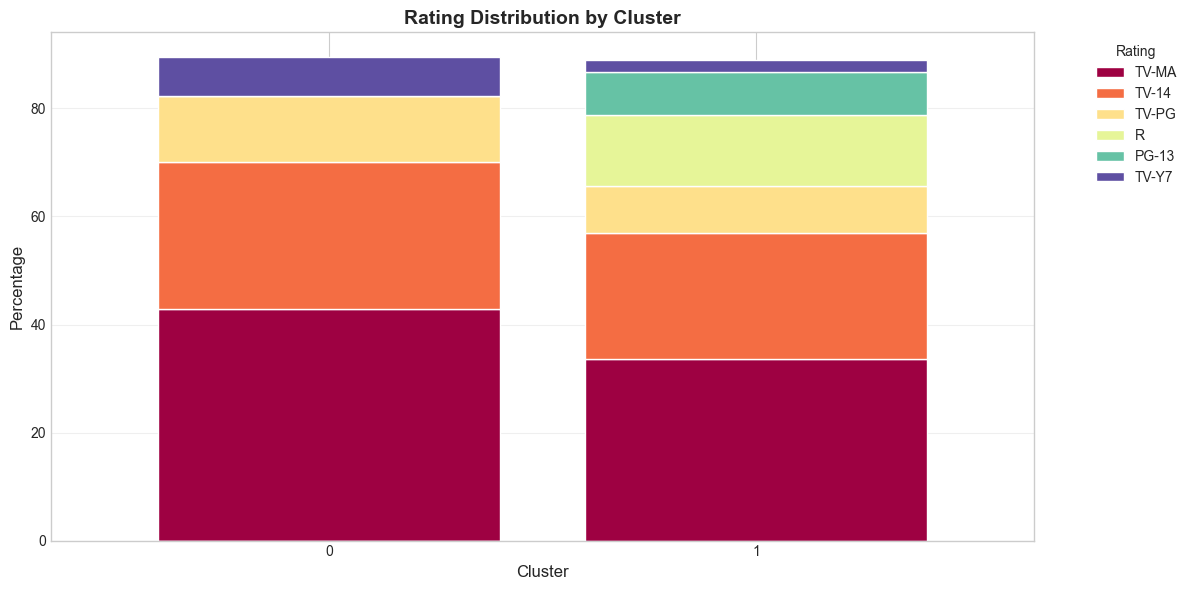

In [51]:
plt.figure(figsize=(12, 6))

rating_cluster = pd.crosstab(netflix_clean['cluster'], netflix_clean['rating'], normalize='index') * 100
top_ratings = netflix_clean['rating'].value_counts().head(6).index
rating_cluster[top_ratings].plot(kind='bar', stacked=True,
                                colormap='Spectral', width=0.8, figsize=(12, 6))
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Rating Distribution by Cluster', fontsize=14, fontweight='bold')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 9f. Country distribution

<Figure size 1400x600 with 0 Axes>

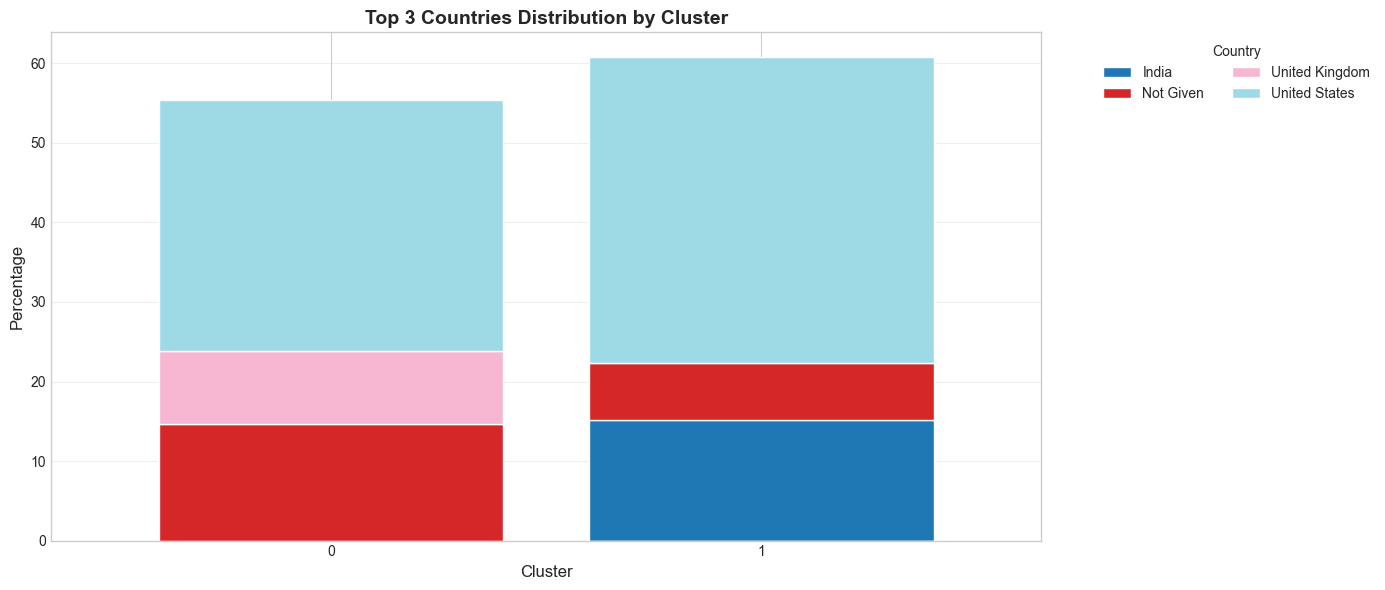

In [52]:
plt.figure(figsize=(14, 6))
country_detailed_data = []
for cluster_id in sorted(netflix_clean['cluster'].unique()):
    cluster_data = netflix_clean[netflix_clean['cluster'] == cluster_id]
    top_countries = cluster_data['country_primary'].value_counts().head(3)
    for country, count in top_countries.items():
        country_detailed_data.append({
            'Cluster': cluster_id,
            'Country': country,
            'Percentage': (count / len(cluster_data)) * 100
        })

country_detailed_df = pd.DataFrame(country_detailed_data)
country_pivot = country_detailed_df.pivot(index='Cluster', columns='Country', values='Percentage').fillna(0)

country_pivot.plot(kind='bar', stacked=True, colormap='tab20', width=0.8, figsize=(14, 6))
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Top 3 Countries Distribution by Cluster', fontsize=14, fontweight='bold')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Cluster Visualization using PCA

PCA Explained Variance:
PC1: 5.986%
PC2: 3.176%
Total: 9.162%


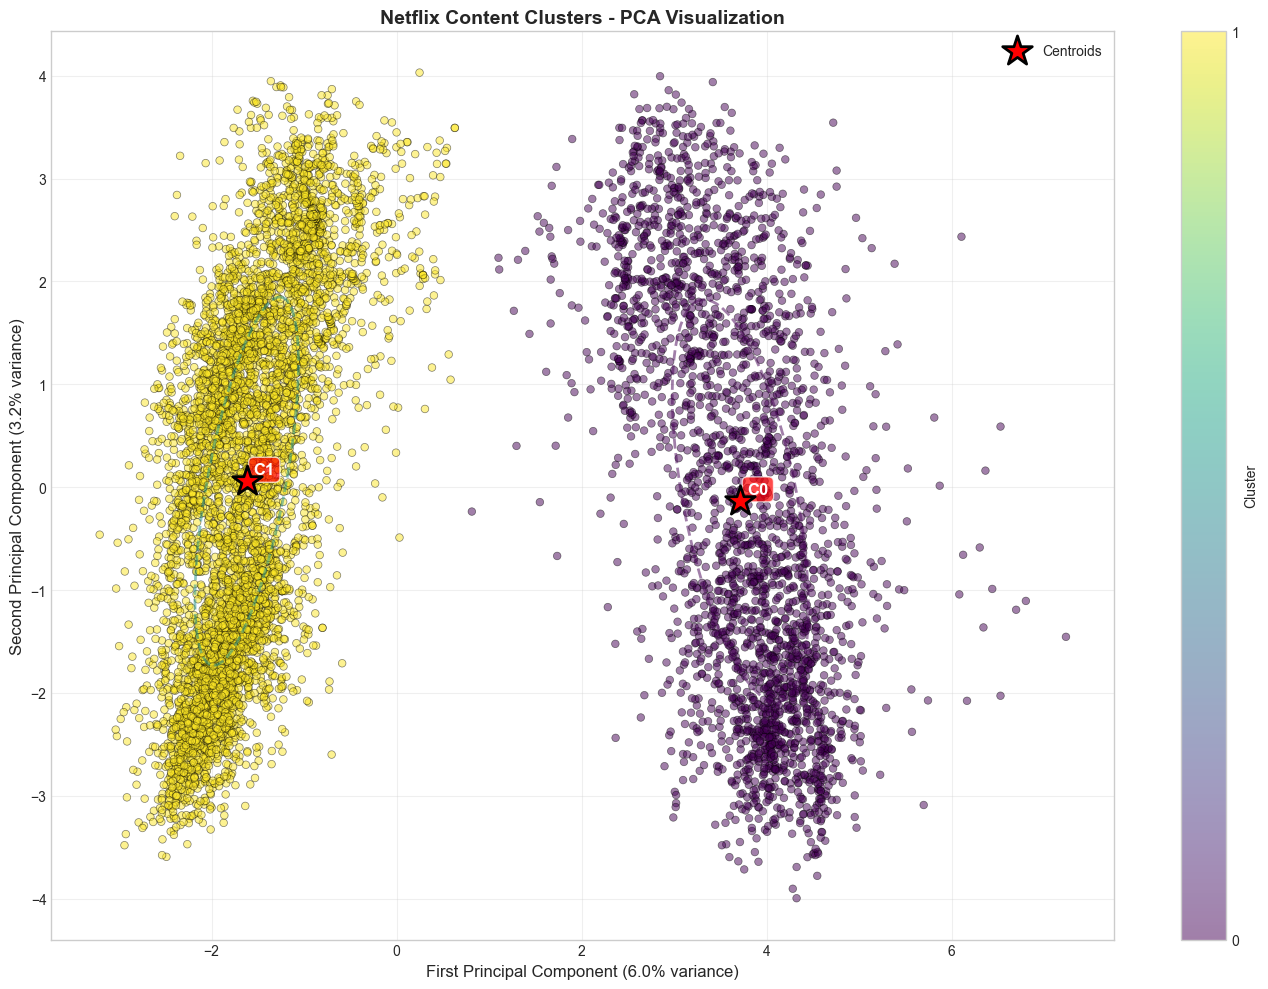

In [53]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA Explained Variance:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.3%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.3%}")
print(f"Total: {sum(pca.explained_variance_ratio_):.3%}")

# Create the visualization
plt.figure(figsize=(14, 10))

# Create scatter plot
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                     c=netflix_clean['cluster'],
                     cmap='viridis',
                     alpha=0.5,
                     s=30,
                     edgecolors='black',
                     linewidth=0.5)

# Plot cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='red',
           marker='*',
           s=500,
           edgecolors='black',
           linewidth=2,
           label='Centroids',
           zorder=10)

# Add cluster labels to centroids
for i, center in enumerate(centers_pca):
    plt.annotate(f'C{i}',
                xy=(center[0], center[1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=12,
                fontweight='bold',
                color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Netflix Content Clusters - PCA Visualization', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster', ticks=range(optimal_k))
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Add cluster boundaries (approximate using convex hull would be better, but keeping it simple)
from matplotlib.patches import Ellipse
for cluster_id in range(optimal_k):
    cluster_points = X_pca[netflix_clean['cluster'] == cluster_id]
    if len(cluster_points) > 0:
        cov = np.cov(cluster_points.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

        ellipse = Ellipse(xy=centers_pca[cluster_id],
                         width=2 * np.sqrt(eigenvalues[0]),
                         height=2 * np.sqrt(eigenvalues[1]),
                         angle=angle,
                         facecolor='none',
                         edgecolor=plt.cm.viridis(cluster_id / optimal_k),
                         linestyle='--',
                         linewidth=2,
                         alpha=0.5)
        plt.gca().add_patch(ellipse)

plt.tight_layout()
plt.show()

## 11. Content-Based Recommendation System

In [54]:
def get_recommendations(title_query, netflix, X_scaled, kmeans_model, n_recommendations=10):
    """
    Get content recommendations based on clustering and feature similarity

    Parameters:
    -----------
    title_query : str
        Title or partial title to search for
    netflix : DataFrame
        The main dataframe with cluster assignments
    X_scaled : array
        Scaled feature matrix
    kmeans_model : KMeans
        Fitted KMeans model
    n_recommendations : int
        Number of recommendations to return
    """

    # Find matching titles
    title_matches = netflix[netflix['title'].str.contains(title_query, case=False, na=False)]

    if title_matches.empty:
        print(f"❌ No matches found for '{title_query}'")
        return None

    # If multiple matches, show them
    if len(title_matches) > 1:
        print(f"Found {len(title_matches)} matches. Using the first one:")
        print(title_matches[['title', 'type', 'genre_primary']].head())
        print()

    # Use first match
    target_idx = title_matches.index[0]
    target_show = netflix.loc[target_idx]
    target_cluster = target_show['cluster']

    # Display target show info
    print("🎬 Target Content:")
    print("="*60)
    print(f"Title: {target_show['title']}")
    print(f"Type: {target_show['type']}")
    print(f"Genre: {target_show['listed_in']}")
    print(f"Rating: {target_show['rating']}")
    print(f"Release Year: {target_show['release_year']}")
    print(f"Cluster: {target_cluster}")

    # Get shows from same cluster
    same_cluster = netflix[netflix['cluster'] == target_cluster]
    same_cluster = same_cluster[same_cluster.index != target_idx]

    if len(same_cluster) == 0:
        print("No other shows in the same cluster!")
        return None

    # Calculate distances
    target_features = X_scaled[target_idx].reshape(1, -1)
    cluster_features = X_scaled[same_cluster.index]
    distances = np.linalg.norm(cluster_features - target_features, axis=1)

    # Get top recommendations
    top_indices = same_cluster.index[np.argsort(distances)[:min(n_recommendations, len(same_cluster))]]
    recommendations = netflix.loc[top_indices].copy()
    recommendations['similarity_score'] = 1 / (1 + distances[np.argsort(distances)[:len(recommendations)]])

    print(f"\n🎯 Top {len(recommendations)} Recommendations:")
    print("="*60)

    for i, (_, show) in enumerate(recommendations.iterrows(), 1):
        print(f"\n{i}. {show['title']}")
        print(f"   Type: {show['type']}")
        print(f"   Genre: {show['listed_in'][:60]}...")
        print(f"   Rating: {show['rating']}")
        print(f"   Release Year: {show['release_year']}")
        print(f"   Similarity Score: {show['similarity_score']:.3f}")

    return recommendations

# Test the recommendation system
print("Content-Based Recommendation System")

# Example recommendation
test_titles = ["Stranger Things", "The Crown", "Black Mirror"]

for title in test_titles:
    print(f"\n{'='*60}")
    recommendations = get_recommendations(title, netflix_clean, X_scaled, kmeans_final, n_recommendations=5)
    if recommendations is not None:
        print(f"Successfully generated recommendations for '{title}'")

Content-Based Recommendation System

Found 2 matches. Using the first one:
                       title     type                 genre_primary
3685         Stranger Things  TV Show                     TV Horror
5200  Beyond Stranger Things  TV Show  Stand-Up Comedy & Talk Shows

🎬 Target Content:
Title: Stranger Things
Type: TV Show
Genre: TV Horror, TV Mysteries, TV Sci-Fi & Fantasy
Rating: TV-14
Release Year: 2019
Cluster: 0

🎯 Top 5 Recommendations:

1. Helix
   Type: TV Show
   Genre: TV Horror, TV Mysteries, TV Sci-Fi & Fantasy...
   Rating: TV-MA
   Release Year: 2015
   Similarity Score: 0.088

2. Chilling Adventures of Sabrina
   Type: TV Show
   Genre: TV Horror, TV Mysteries, TV Sci-Fi & Fantasy...
   Rating: TV-14
   Release Year: 2020
   Similarity Score: 0.085

3. Nightflyers
   Type: TV Show
   Genre: TV Horror, TV Mysteries, TV Sci-Fi & Fantasy...
   Rating: TV-MA
   Release Year: 2018
   Similarity Score: 0.080

4. Midnight Mass
   Type: TV Show
   Genre: TV Dramas, TV 

## 12. Cluster Interpretation and Business Insights

In [55]:
cluster_interpretations = []

for cluster_id in sorted(netflix_clean['cluster'].unique()):
    cluster_data = netflix_clean[netflix_clean['cluster'] == cluster_id]

    # Get key characteristics
    interpretation = {
        'cluster_id': cluster_id,
        'size': len(cluster_data),
        'type_dominance': cluster_data['type'].value_counts().iloc[0] / len(cluster_data),
        'primary_type': cluster_data['type'].mode()[0],
        'top_genres': cluster_data['genre_primary'].value_counts().head(3).to_dict(),
        'avg_release_year': cluster_data['release_year'].mean(),
        'year_std': cluster_data['release_year'].std(),
        'primary_rating': cluster_data['rating'].mode()[0],
        'rating_diversity': cluster_data['rating'].nunique(),
        'avg_cast_size': cluster_data['cast_size'].mean(),
        'international_diversity': cluster_data['n_countries'].mean()
    }

    cluster_interpretations.append(interpretation)

# Create interpretation labels
print("Cluster Labels and Characteristics:\n")

cluster_labels = {
    0: "Classic Movies",
    1: "International TV Series",
    2: "Family-Friendly Content",
    3: "Recent Blockbusters",
    4: "Niche Documentaries",
    5: "Mature Drama Series",
    6: "Comedy Specials",
    7: "Action & Thrillers"
}

for interp in cluster_interpretations:
    cluster_id = interp['cluster_id']

    # Determine cluster label based on characteristics
    if interp['primary_type'] == 'Movie' and interp['avg_release_year'] < 2010:
        label = "Classic Movies"
    elif interp['primary_type'] == 'TV Show' and interp['international_diversity'] > 1.5:
        label = "International TV Series"
    elif 'Family' in str(interp['top_genres']) or 'Kids' in str(interp['top_genres']):
        label = "Family-Friendly Content"
    elif interp['avg_release_year'] > 2018:
        label = "Recent Releases"
    elif 'Documentary' in str(interp['top_genres']):
        label = "Documentary Content"
    elif 'Drama' in str(interp['top_genres']) and interp['primary_type'] == 'TV Show':
        label = "Drama Series"
    elif 'Comedy' in str(interp['top_genres']):
        label = "Comedy Content"
    else:
        label = f"Mixed Content Group {cluster_id}"

    print(f"Cluster {cluster_id}: {label}")
    print(f"- Size: {interp['size']} titles ({interp['size']/len(netflix_clean)*100:.1f}%)")
    print(f"- Primary Type: {interp['primary_type']} ({interp['type_dominance']*100:.0f}% dominance)")
    print(f"- Top Genre: {list(interp['top_genres'].keys())[0]}")
    print(f"- Average Year: {interp['avg_release_year']:.0f} (±{interp['year_std']:.0f})")
    print(f"- Primary Rating: {interp['primary_rating']}")
    print(f"- International Diversity: {'High' if interp['international_diversity'] > 1.5 else 'Low'}")
    print()

Cluster Labels and Characteristics:

Cluster 0: Family-Friendly Content
- Size: 2675 titles (30.4%)
- Primary Type: TV Show (100% dominance)
- Top Genre: International TV Shows
- Average Year: 2017 (±6)
- Primary Rating: TV-MA
- International Diversity: Low

Cluster 1: Mixed Content Group 1
- Size: 6132 titles (69.6%)
- Primary Type: Movie (100% dominance)
- Top Genre: Dramas
- Average Year: 2013 (±10)
- Primary Rating: TV-MA
- International Diversity: Low



## 13. Save Results and Export

In [56]:
cluster_label_map = {}
for i in range(optimal_k):
    if i < len(cluster_labels):
        cluster_label_map[i] = cluster_labels[i]
    else:
        cluster_label_map[i] = f"Cluster_{i}"

netflix_clean['cluster_label'] = netflix_clean['cluster'].map(cluster_label_map)

# Save to CSV
output_file = 'netflix_clustering_results.csv'
netflix_clean.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Save cluster summary
summary_data = {
    'Cluster': [],
    'Label': [],
    'Size': [],
    'Percentage': [],
    'Primary_Type': [],
    'Top_Genre': [],
    'Top_Rating': [],
    'Avg_Release_Year': []
}

for cluster_id in sorted(netflix_clean['cluster'].unique()):
    cluster_data = netflix_clean[netflix_clean['cluster'] == cluster_id]
    summary_data['Cluster'].append(cluster_id)
    summary_data['Label'].append(cluster_label_map.get(cluster_id, f"Cluster_{cluster_id}"))
    summary_data['Size'].append(len(cluster_data))
    summary_data['Percentage'].append(f"{len(cluster_data)/len(netflix_clean)*100:.1f}%")
    summary_data['Primary_Type'].append(cluster_data['type'].mode()[0])
    summary_data['Top_Genre'].append(cluster_data['genre_primary'].mode()[0])
    summary_data['Top_Rating'].append(cluster_data['rating'].mode()[0])
    summary_data['Avg_Release_Year'].append(int(cluster_data['release_year'].mean()))

summary_netflix = pd.DataFrame(summary_data)
summary_file = 'netflix_clustering_summary.csv'
summary_netflix.to_csv(summary_file, index=False)
print(f"Summary saved to {summary_file}")

Results saved to netflix_clustering_results.csv
Summary saved to netflix_clustering_summary.csv


## 14 Display final summary

In [57]:
print("Final Clustering Summary:")
print(summary_netflix.to_string(index=False))

Final Clustering Summary:
 Cluster                   Label  Size Percentage Primary_Type              Top_Genre Top_Rating  Avg_Release_Year
       0          Classic Movies  2675      30.4%      TV Show International TV Shows      TV-MA              2016
       1 International TV Series  6132      69.6%        Movie                 Dramas      TV-MA              2013


In [58]:
print(f"Clusters identified: {optimal_k}")
print(f"Total features used: {X_scaled.shape[1]}")
print(f"Titles analyzed: {len(netflix_clean)}")

Clusters identified: 2
Total features used: 107
Titles analyzed: 8807
